In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import japanize_matplotlib 

import glob
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import networkx as nx

%matplotlib inline 

In [10]:
from PIL import Image, ImageEnhance, ImageFilter
import os
import random

input_root = 'img/resistor_images_jpg'
output_root = 'img/resistor_images_augmented_3'

# 保存用接尾辞（各種Augmentation名）
suffixes = {
    "original": "",  # 元画像（無加工）

    "flip": "_flip",  # 左右反転（水平フリップ）→ 左右対称性の学習に有効
    "flip_vertical": "_flipv",  # 上下反転（垂直フリップ）→ 実際には非現実だが，頑健性向上に使える

    "rotate": "_rotate180",  # 180度回転 → 上下左右どこから見ても同じような識別ができるように
    "rotate_small": "_rotate_small",  # 小さな回転（例：±10度）→ 撮影角度のばらつきへの対応

    "bright": "_bright",  # 明るさを上げる → 照明条件が明るい場合のデータ拡張
    "dark": "_dark",  # 明るさを下げる → 暗所撮影への対応

    "saturation_up": "_satup",  # 彩度を上げる → 原色が強調された状態を学習
    "saturation_down": "_satdown",  # 彩度を下げる → くすんだ色や白飛び状態への対応

    "contrast_up": "_contup",  # コントラストを上げる → 色の境界がくっきりした状態
    "contrast_down": "_contdown",  # コントラストを下げる → 色の境界がぼやけた状態

    #"blur": "_blur",  # ぼかし（Gaussianなど）→ ピントが甘い画像への対応

    #"random_crop": "_crop"  # ランダム切り抜き → 一部が欠けていても判別できるようにする
}


def random_crop(img, crop_size):
    width, height = img.size
    left = (width - crop_size) // 2
    top = (height - crop_size) // 2
    right = left + crop_size
    bottom = top + crop_size
    cropped = img.crop((left, top, right, bottom))
    return cropped.resize((width, height))

for root, dirs, files in os.walk(input_root):
    for file in files:
        if file.lower().endswith(".jpg"):
            input_path = os.path.join(root, file)
            relative_path = os.path.relpath(root, input_root)
            output_dir = os.path.join(output_root, relative_path)
            os.makedirs(output_dir, exist_ok=True)

            try:
                img = Image.open(input_path)

                augmentations = {
                    "original": img,
                    "flip": img.transpose(Image.FLIP_LEFT_RIGHT),
                    "flip_vertical": img.transpose(Image.FLIP_TOP_BOTTOM),
                    "rotate": img.rotate(180),
                    "rotate_small": img.rotate(random.uniform(-15, 15)),
                    "bright": ImageEnhance.Brightness(img).enhance(1.5),
                    "dark": ImageEnhance.Brightness(img).enhance(0.7),
                    "saturation_up": ImageEnhance.Color(img).enhance(1.5),
                    "saturation_down": ImageEnhance.Color(img).enhance(0.7),
                    "contrast_up": ImageEnhance.Contrast(img).enhance(1.5),
                    "contrast_down": ImageEnhance.Contrast(img).enhance(0.7),
                    #"blur": img.filter(ImageFilter.GaussianBlur(radius=1)),
                    #"random_crop": random_crop(img, int(min(img.size)*0.9))
                }

                base_filename = os.path.splitext(file)[0]
                for key, aug_img in augmentations.items():
                    suffix = suffixes[key]
                    output_filename = f"{base_filename}{suffix}.jpg"
                    output_path = os.path.join(output_dir, output_filename)
                    aug_img.save(output_path, format="JPEG")
                    print(f"✅ 保存: {output_path}")

            except Exception as e:
                print(f"❌ エラー: {input_path}: {e}")


✅ 保存: img/resistor_images_augmented_3/23KR/right/IMG_7455.jpg
✅ 保存: img/resistor_images_augmented_3/23KR/right/IMG_7455_flip.jpg
✅ 保存: img/resistor_images_augmented_3/23KR/right/IMG_7455_flipv.jpg
✅ 保存: img/resistor_images_augmented_3/23KR/right/IMG_7455_rotate180.jpg
✅ 保存: img/resistor_images_augmented_3/23KR/right/IMG_7455_rotate_small.jpg
✅ 保存: img/resistor_images_augmented_3/23KR/right/IMG_7455_bright.jpg
✅ 保存: img/resistor_images_augmented_3/23KR/right/IMG_7455_dark.jpg
✅ 保存: img/resistor_images_augmented_3/23KR/right/IMG_7455_satup.jpg
✅ 保存: img/resistor_images_augmented_3/23KR/right/IMG_7455_satdown.jpg
✅ 保存: img/resistor_images_augmented_3/23KR/right/IMG_7455_contup.jpg
✅ 保存: img/resistor_images_augmented_3/23KR/right/IMG_7455_contdown.jpg
✅ 保存: img/resistor_images_augmented_3/23KR/right/IMG_7457.jpg
✅ 保存: img/resistor_images_augmented_3/23KR/right/IMG_7457_flip.jpg
✅ 保存: img/resistor_images_augmented_3/23KR/right/IMG_7457_flipv.jpg
✅ 保存: img/resistor_images_augmented_3/23KR/ri

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# パラメータ
IMG_SIZE = 64
DATA_DIR = 'img/resistor_images_augmented_2'

# ラベル名を取得（フォルダ名）
# ラベル名を取得（フォルダ名のみ、隠しファイルやファイルを除外）
labels = sorted([
    name for name in os.listdir(DATA_DIR)
    if os.path.isdir(os.path.join(DATA_DIR, name)) and not name.startswith('.')
])

label_to_index = {label: i for i, label in enumerate(labels)}

# データ読み込み
X = []
y = []

for label in labels:
    label_dir = os.path.join(DATA_DIR, label)
    for subfolder, _, files in os.walk(label_dir):
        for file in files:
            if file.endswith('.jpg'):
                img_path = os.path.join(subfolder, file)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize((IMG_SIZE, IMG_SIZE))
                    X.append(np.array(img))
                    y.append(label_to_index[label])
                except:
                    print(f"❌ 読み込み失敗: {img_path}")

X = np.array(X) / 255.0  # 正規化
y = to_categorical(y)    # One-hot encoding

# データ分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"✅ データ形状: {X_train.shape}, {y_train.shape}")


✅ データ形状: (1300, 64, 64, 3), (1300, 5)


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# モデル構築
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')  # クラス数に合わせる
])

# コンパイル
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# コールバック（早期終了）
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 学習
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping]
)

# モデル保存
model.save('resistor_model.h5')
print("✅ モデル学習と保存が完了しました")


/Users/yasuo/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-21 18:13:21.007262: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-07-21 18:13:21.007351: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-07-21 18:13:21.007357: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
I0000 00:00:1753089201.007378 3875744 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753089201.007407 3875744 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 

Epoch 1/30


2025-07-21 18:13:22.467679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.2140 - loss: 1.6909 - val_accuracy: 0.1723 - val_loss: 1.6109
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1930 - loss: 1.6125 - val_accuracy: 0.1723 - val_loss: 1.6107
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.1982 - loss: 1.6096 - val_accuracy: 0.1846 - val_loss: 1.6166
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2337 - loss: 1.5966 - val_accuracy: 0.3662 - val_loss: 1.5530
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3143 - loss: 1.5410 - val_accuracy: 0.3631 - val_loss: 1.4325
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3818 - loss: 1.4643 - val_accuracy: 0.3908 - val_loss: 1.3390
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4252 - loss: 1.3805 - val_accuracy: 0.4831 - val_loss: 1.1978
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4631 - loss: 1.3031 - val_accuracy: 0.5569 - val_loss: 1.

✅ モデル学習と保存が完了しました


/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_50285/3721676702.py:22: UserWarning: Glyph 12456 (\N{KATAKANA LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_50285/3721676702.py:22: UserWarning: Glyph 12509 (\N{KATAKANA LETTER PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_50285/3721676702.py:22: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_50285/3721676702.py:22: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_50285/3721676702.py:22: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/

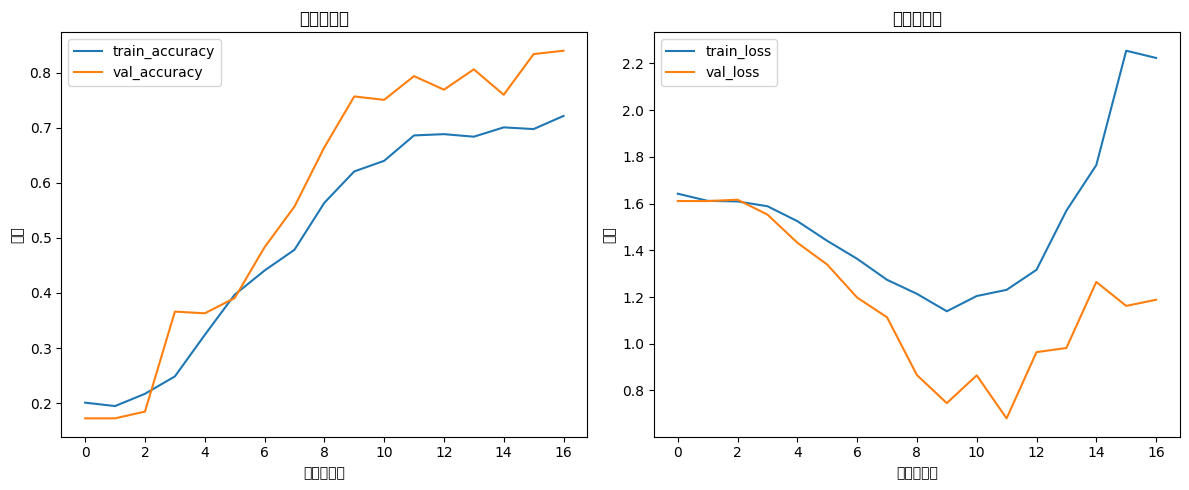

In [3]:
import matplotlib.pyplot as plt

# 精度の推移
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('エポック数')
plt.ylabel('精度')
plt.title('精度の推移')
plt.legend()

# 損失の推移
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('エポック数')
plt.ylabel('損失')
plt.title('損失の推移')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_50285/1178953607.py:22: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_50285/1178953607.py:22: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_50285/1178953607.py:22: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_50285/1178953607.py:22: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/yasuo/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/U

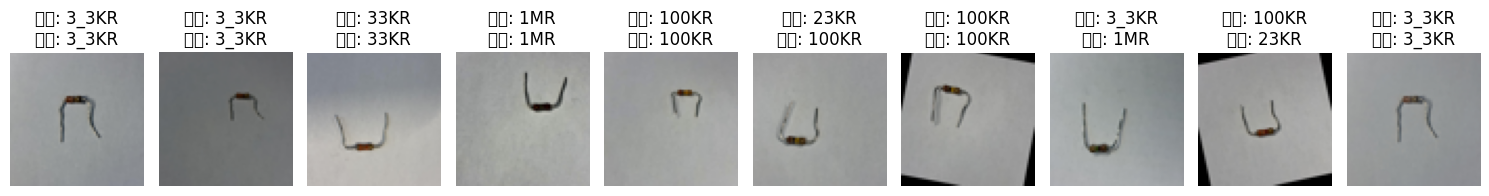

In [4]:
import random

# ラベル辞書（index → ラベル名）を再構成
index_to_label = {i: label for label, i in label_to_index.items()}

# ランダムに予測して表示
n = 10
plt.figure(figsize=(15, 3))
for i in range(n):
    idx = random.randint(0, len(X_val) - 1)
    img = X_val[idx]
    true_label = np.argmax(y_val[idx])
    
    pred = model.predict(np.expand_dims(img, axis=0))
    pred_label = np.argmax(pred[0])
    
    plt.subplot(1, n, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'予測: {index_to_label[pred_label]}\n正解: {index_to_label[true_label]}')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_50285/1458090480.py:31: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_50285/1458090480.py:31: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_50285/1458090480.py:31: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_50285/1458090480.py:31: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


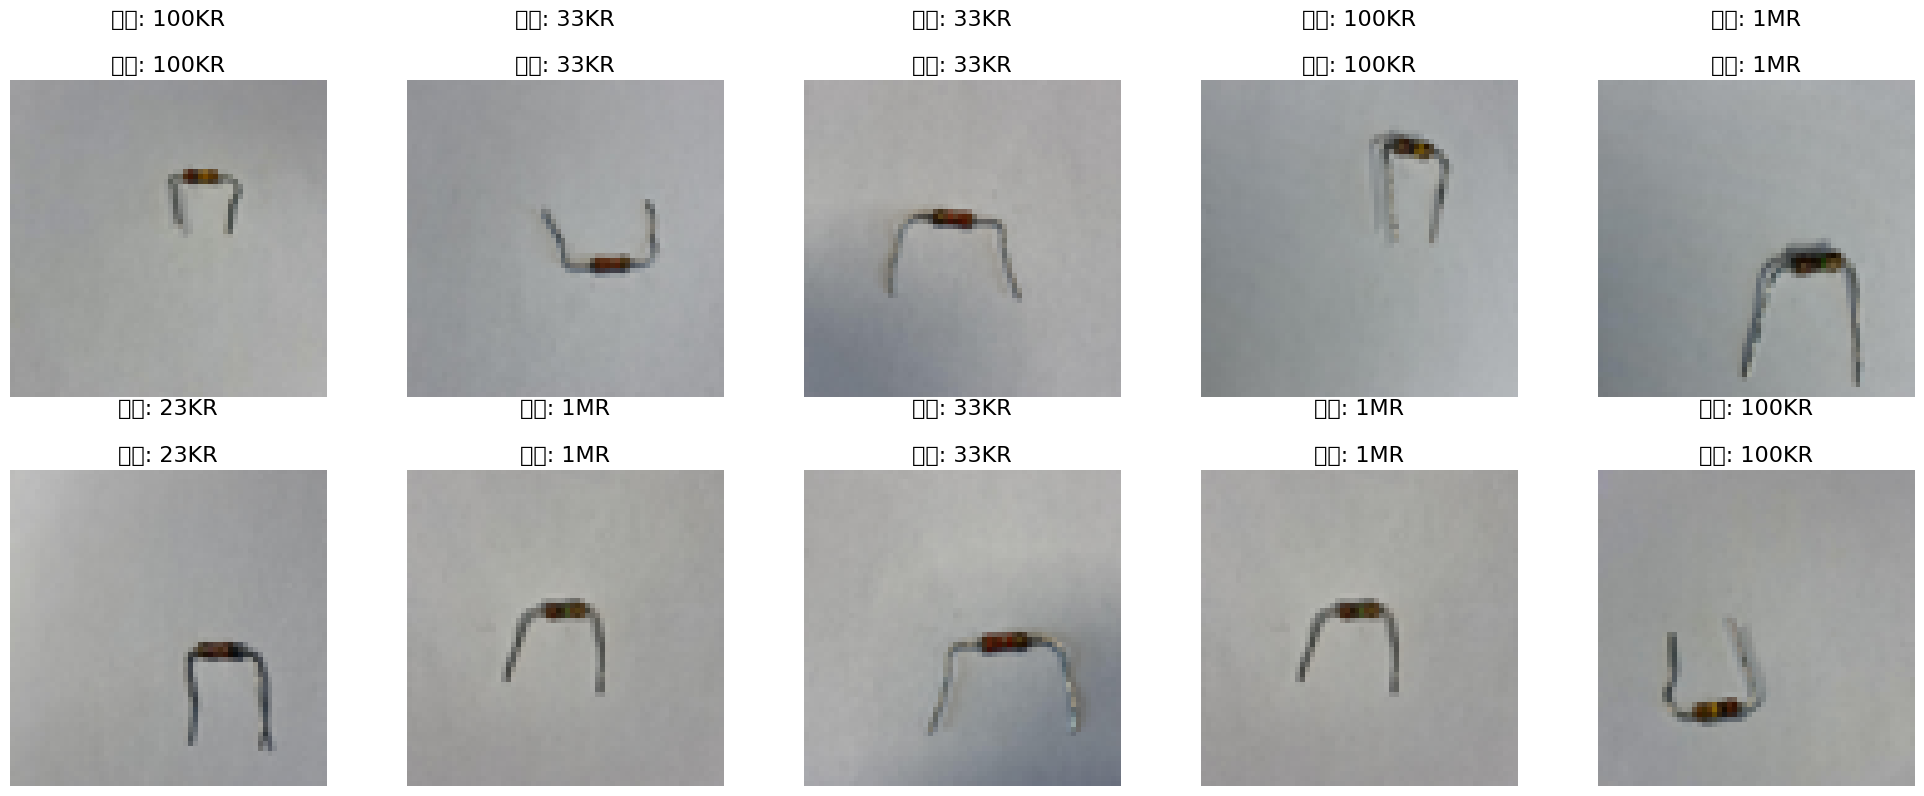

In [5]:
import random
import matplotlib.pyplot as plt
import numpy as np

# ラベル辞書（index → ラベル名）を再構成
index_to_label = {i: label for label, i in label_to_index.items()}

# 表示数とレイアウト
n = 10  # 枚数（偶数推奨）
rows = 2
cols = n // rows

plt.figure(figsize=(cols * 4, rows * 4))  # 画像サイズ大きめに調整

for i in range(n):
    idx = random.randint(0, len(X_val) - 1)
    img = X_val[idx]
    true_label = np.argmax(y_val[idx])
    
    pred = model.predict(np.expand_dims(img, axis=0))
    pred_label = np.argmax(pred[0])
    
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
    
    # タイトル（フォントサイズ調整）
    title_text = f'予測: {index_to_label[pred_label]}\n\n正解: {index_to_label[true_label]}'
    plt.title(title_text, fontsize=16)

plt.tight_layout()
plt.show()


In [6]:
print(labels)
print(f"クラス数: {len(labels)}")


['100KR', '1MR', '23KR', '33KR', '3_3KR']
クラス数: 5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/Users/yasuo/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yasuo/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yasuo/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yasuo/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12505 (\N{KATAKANA LETTER BE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yasuo/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sa

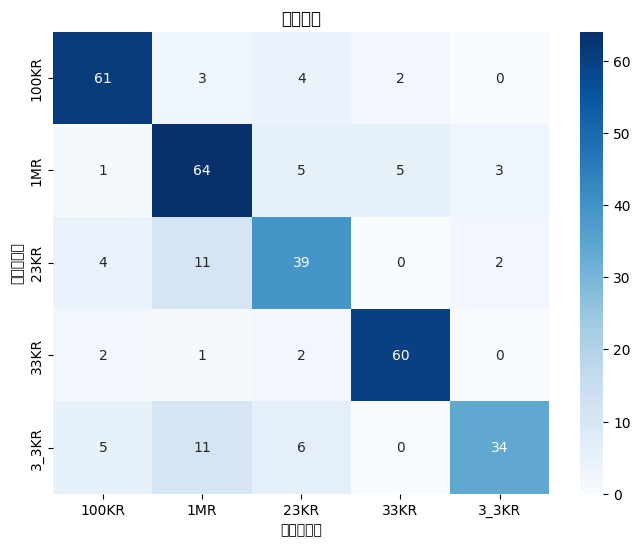

              precision    recall  f1-score   support

       100KR       0.84      0.87      0.85        70
         1MR       0.71      0.82      0.76        78
        23KR       0.70      0.70      0.70        56
        33KR       0.90      0.92      0.91        65
       3_3KR       0.87      0.61      0.72        56

    accuracy                           0.79       325
   macro avg       0.80      0.78      0.79       325
weighted avg       0.80      0.79      0.79       325



In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ラベル名を取得（フォルダ名） ※隠しファイル除外
#labels = sorted([d for d in os.listdir(DATA_DIR) if not d.startswith('.')])
#label_to_index = {label: i for i, label in enumerate(labels)}


# 予測と正解を取得
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

# 混同行列
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('予測ラベル')
plt.ylabel('正解ラベル')
plt.title('混同行列')
plt.show()

# 詳細な分類レポート
print(classification_report(y_true_labels, y_pred_labels, target_names=labels))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_50285/3805438684.py:36: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_50285/3805438684.py:36: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_50285/3805438684.py:36: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_50285/3805438684.py:36: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


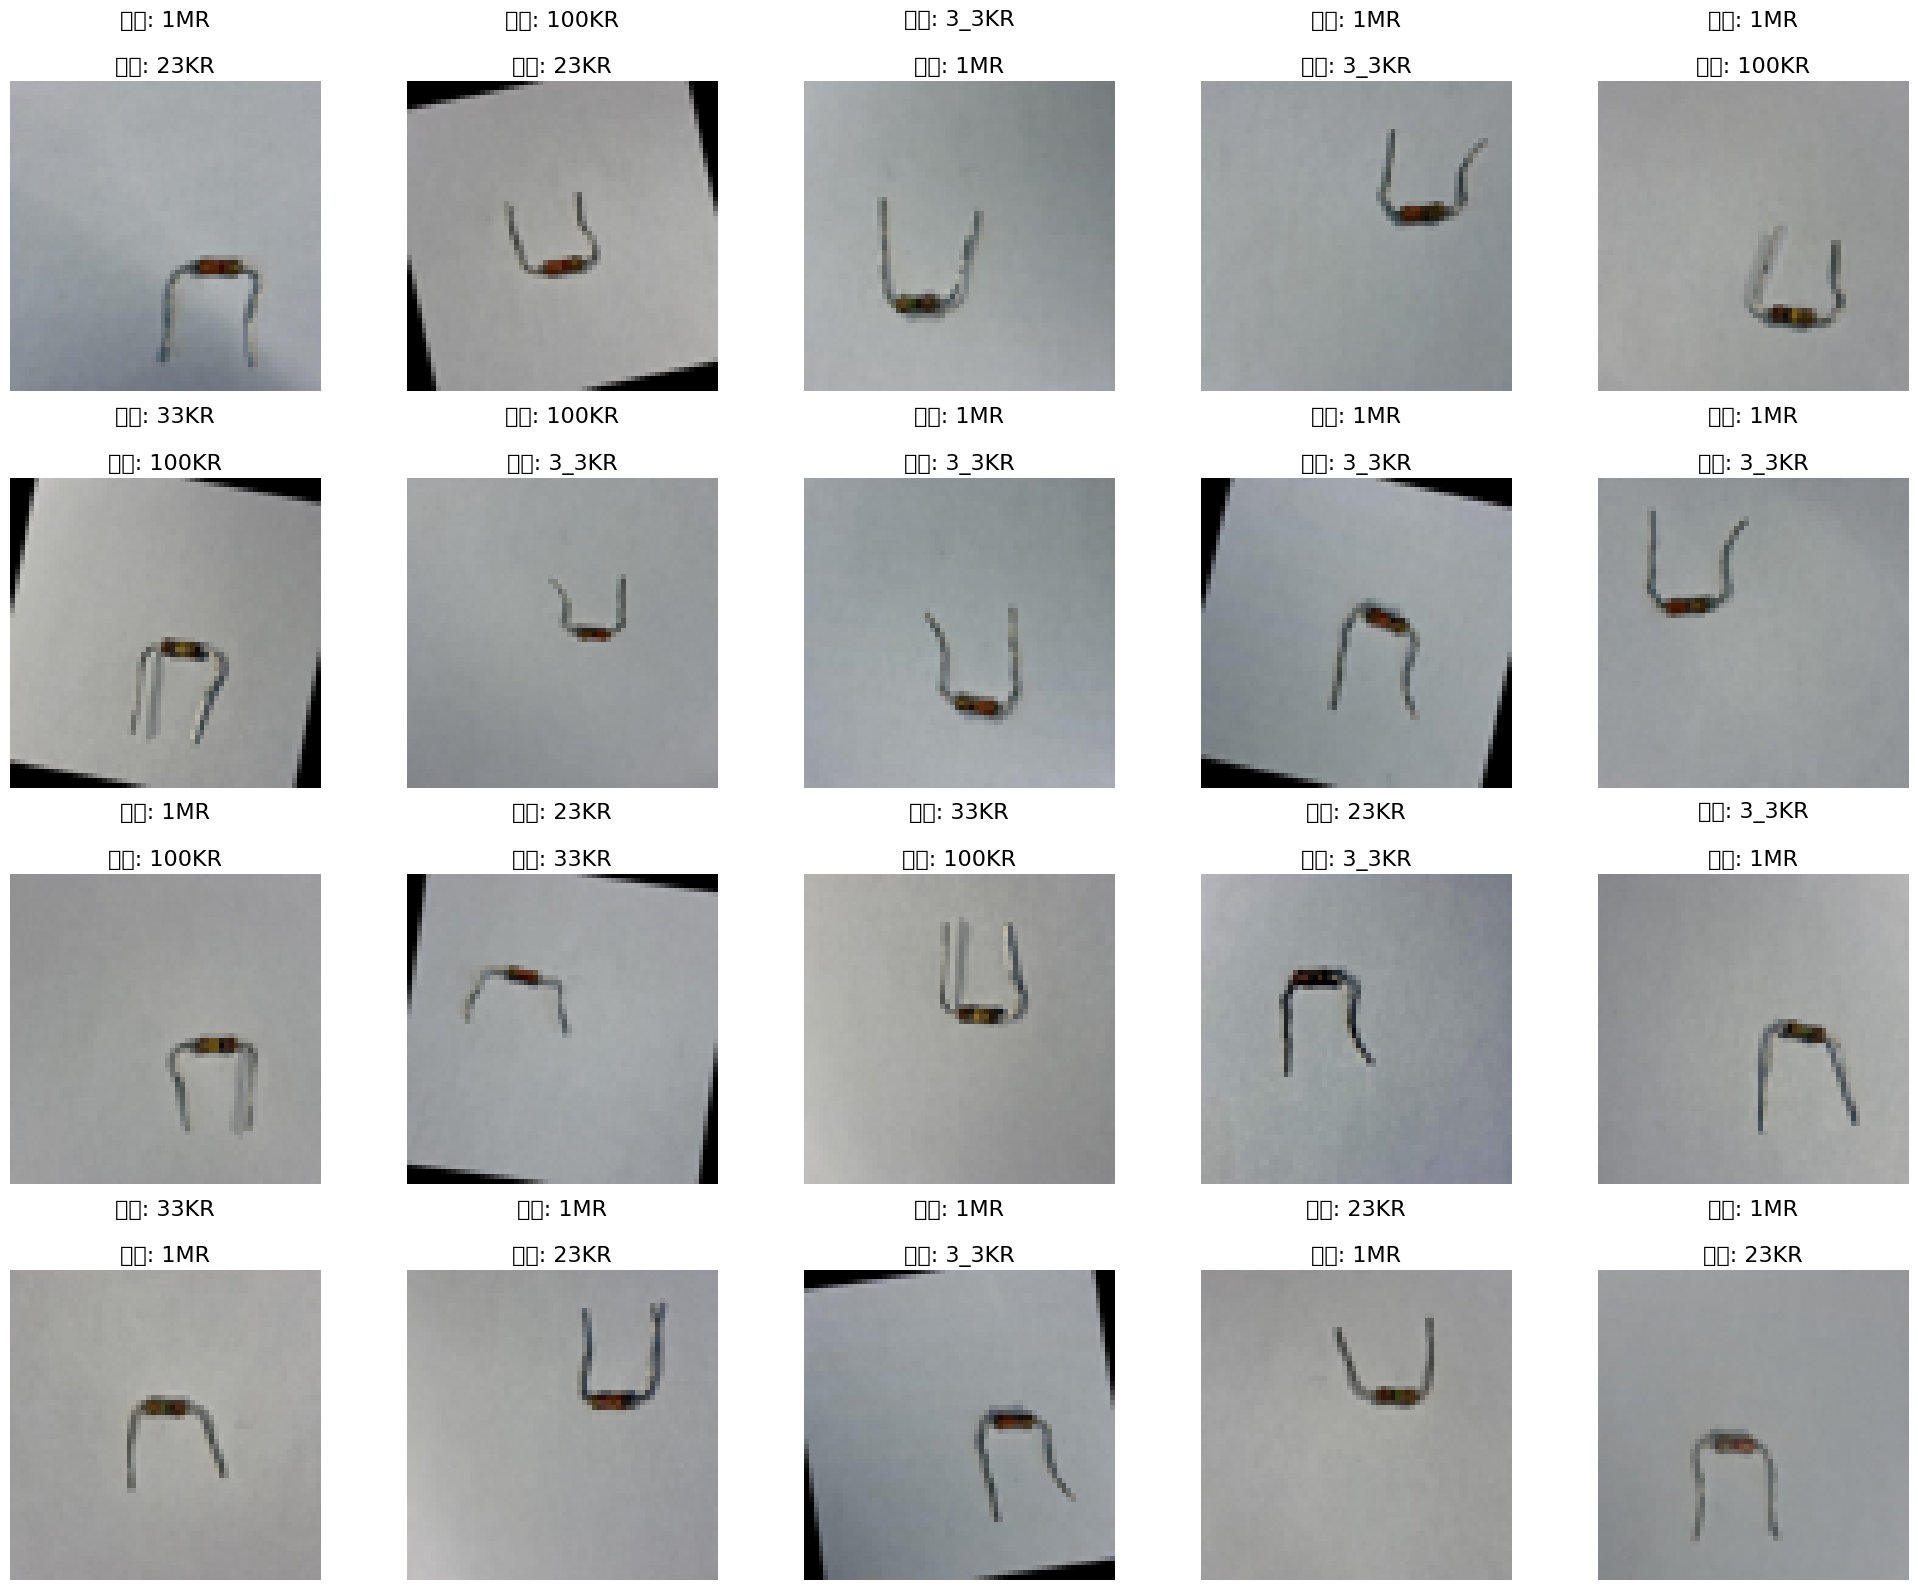

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# ラベル辞書（index → ラベル名）を再構成
index_to_label = {i: label for label, i in label_to_index.items()}

# 予測をまとめて取得
preds = model.predict(X_val)
y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(y_val, axis=1)

# 誤分類のインデックス取得
misclassified_indices = np.where(y_pred != y_true)[0]

# 表示数（例：最大10件）
n = min(20, len(misclassified_indices))
rows = 4
cols = (n + 1) // rows

plt.figure(figsize=(cols * 4, rows * 4))

for i in range(n):
    idx = misclassified_indices[i]
    img = X_val[idx]
    true_label = y_true[idx]
    pred_label = y_pred[idx]

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
    
    # タイトル（誤分類のラベル表示）
    title_text = f'予測: {index_to_label[pred_label]}\n\n正解: {index_to_label[true_label]}'
    plt.title(title_text, fontsize=16)

plt.tight_layout()
plt.show()
